# Data Preparation

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

In [16]:
METADATA_PATH = '../UrbanSound8K/metadata/UrbanSound8K.csv'
AUDIO_BASE_PATH = '../UrbanSound8K/audio'

In [17]:
def load_audio(file_path, sr=22050):
    """Load audio file and return signal and sample rate"""
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

In [18]:
def process_channels(audio, mode='mono'):
    """
    Process audio channels (mono/stereo/average)
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio array, shape (samples,) or (samples, channels)
    mode : str
        'mono' - take first channel only
        'stereo' - convert to stereo (duplicate if mono)
        'avg' - average all channels
        'original' - keep as is
    
    Returns:
    --------
    np.ndarray : Processed audio
    """
    if mode == 'mono':
        new_audio = audio if audio.ndim == 1 else audio[:, :1]
    elif mode == 'stereo':
        new_audio = np.stack([audio]*2).T if audio.ndim == 1 else audio
    elif mode == 'avg':
        new_audio = audio.mean(axis=1) if audio.ndim > 1 else audio
        new_audio = new_audio[:, None]
    else:
        new_audio = audio
    return new_audio

In [19]:
def add_noise(audio, prob=0.5, noise_factor=0.005, noise_type='normal'):
    """
    Add random noise to audio signal
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying noise (0-1)
    noise_factor : float
        Standard deviation/range of noise
    noise_type : str
        'normal' - Gaussian noise
        'uniform' - Uniform noise
        'half' - Half-normal (non-negative) noise
    
    Returns:
    --------
    np.ndarray : Noisy audio
    """
    if np.random.rand() > prob:
        return audio
    
    length = audio.shape[0]
    
    if noise_type == 'normal':
        noise = np.random.normal(0, noise_factor, length)
    elif noise_type == 'uniform':
        noise = np.random.uniform(-noise_factor, noise_factor, length)
    elif noise_type == 'half':
        noise = np.clip(np.abs(np.random.normal(0, noise_factor, length)), 
                       a_min=0.0, a_max=0.8)
    else:
        raise ValueError(f'Unknown noise type: {noise_type}')
    
    noise = noise[:, None] if audio.ndim > 1 else noise
    return audio + noise.astype(np.float32)

In [20]:
def random_crop(audio, prob=0.5, max_crop_ratio=0.3):
    """
    Randomly crop audio to shorter duration
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying crop
    max_crop_ratio : float
        Maximum ratio to crop (0-0.9)
    
    Returns:
    --------
    np.ndarray : Cropped audio
    """
    if np.random.rand() > prob:
        return audio
    
    # Generate random crop ratio
    crop_ratio = np.random.uniform(0, max_crop_ratio)
    crop_ratio = np.clip(crop_ratio, 0, 0.9)
    
    # Calculate new length
    length = audio.shape[0]
    new_length = int(np.round(length * (1 - crop_ratio)))
    
    # Random start position
    max_start = length - new_length + 1
    ind_start = np.random.randint(0, max_start)
    ind_end = ind_start + new_length
    
    cropped = audio[ind_start:ind_end]
    
    # Avoid zero tensor
    if np.sum(np.abs(cropped)) == 0:
        cropped = cropped + 1e-8
    
    return cropped

In [21]:
def modify_duration(audio, target_duration):
    """
    Modify audio to target duration (crop or pad/repeat)
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    target_duration : int
        Target number of samples
    
    Returns:
    --------
    np.ndarray : Modified audio
    """
    current_length = len(audio)
    
    if target_duration < current_length:
        # Crop randomly
        max_index_start = current_length - target_duration
        index_start = np.random.randint(0, max_index_start + 1)
        index_end = index_start + target_duration
        new_audio = audio[index_start:index_end]
    else:
        # Pad by repeating
        ratio = target_duration / current_length
        full_reps = int(ratio)
        remaining = int(np.round(current_length * (ratio % 1)))
        
        repeated = [audio] * full_reps
        if remaining > 0:
            repeated.append(audio[:remaining])
        
        new_audio = np.concatenate(repeated, axis=0)
    
    return new_audio

In [22]:
def augment_audio(audio, prob=0.5, noise_factor=0.01, noise_type='uniform'):
    """
    Apply general augmentation 
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying augmentation
    noise_factor : float
        Magnitude of augmentation
    noise_type : str
        Type of noise distribution
    
    Returns:
    --------
    np.ndarray : Augmented audio
    """
    if np.random.rand() > prob:
        return audio
    
    if noise_type == 'normal':
        noise = np.random.normal(0, noise_factor, audio.shape)
    elif noise_type == 'uniform':
        noise = np.random.uniform(-noise_factor, noise_factor, audio.shape)
    elif noise_type == 'half':
        noise = np.clip(np.abs(np.random.normal(0, noise_factor, audio.shape)),
                       a_min=0.0, a_max=0.8)
    else:
        raise ValueError(f'Unknown noise type: {noise_type}')
    
    return audio + noise.astype(np.float32)

def _pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def _time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

In [23]:
import random
import uuid
import soundfile as sf

def balance_raw_data_with_augmentation(df_train_fold, audio_base_path, sr):
    """
    Tackles class imbalance by generating raw audio samples for minority classes
    using noise, pitch shift, and time stretch.

    Returns:
        A DataFrame with the EXACT SAME STRUCTURE as df_train_fold, 
        plus 'is_augmented' flag, where augmented samples have new filenames.
    """
    original_columns = df_train_fold.columns.tolist()

    class_counts = df_train_fold['class'].value_counts()
    majority_count = class_counts.max()

    minority_df = df_train_fold[df_train_fold['class'].apply(lambda x: class_counts[x] < majority_count)]

    augmented_rows = []
    minority_groups = minority_df.groupby('class')

    for cls, group_df in minority_groups:
        current_count = len(group_df)
        samples_to_generate = majority_count - current_count

        original_samples = []
        original_rows = []

        for _, row in group_df.iterrows():
            file_path = os.path.join(
                audio_base_path,
                f"fold{row['fold']}",
                row['slice_file_name']
            )

            try:
                audio, _ = load_audio(file_path, sr=sr)
                original_samples.append(audio)
                original_rows.append(row)

            except Exception:
                continue

        if not original_samples:
            continue

        for _ in range(samples_to_generate):
            # pick a random row to copy metadata from
            idx = random.randint(0, len(original_samples) - 1)
            original_audio = original_samples[idx]
            original_row = original_rows[idx]

            tech = random.choice(['noise', 'pitch_shift', 'time_stretch'])

            if tech == 'noise':
                augmented_audio = augment_audio(
                    original_audio,
                    prob=1.0,
                    noise_factor=random.uniform(0.005, 0.05),
                    noise_type=random.choice(['normal', 'uniform'])
                )

            elif tech == 'pitch_shift':
                augmented_audio = _pitch_shift(
                    original_audio, sr, n_steps=random.uniform(-3, 3)
                )

            elif tech == 'time_stretch':
                augmented_audio = _time_stretch(
                    original_audio, rate=random.uniform(0.8, 1.2)
                )

            new_filename = f"aug_{uuid.uuid4().hex[:8]}.wav"

            save_path = os.path.join(
                audio_base_path,
                f"fold{original_row['fold']}",
                new_filename
            )

            sf.write(save_path, augmented_audio, sr)

            new_row = original_row.copy()
            new_row['slice_file_name'] = new_filename
            new_row['is_augmented'] = True

            augmented_rows.append(new_row)

    if len(augmented_rows) > 0:
        df_aug = pd.DataFrame(augmented_rows)

        for col in original_columns:
            if col not in df_aug.columns:
                df_aug[col] = None

        out_df = pd.concat([df_train_fold, df_aug], ignore_index=True)

        cols = original_columns + (['is_augmented'] if 'is_augmented' in out_df else [])
        out_df = out_df[cols]

        return out_df

    df_train_fold['is_augmented'] = False
    return df_train_fold

In [24]:
def preprocess_audio_pipeline(audio, mode='train', 
                              channel_mode='mono',
                              noise_prob=0.5, noise_factor=0.005, noise_type='normal',
                              crop_prob=0.5, max_crop_ratio=0.3,
                              augment_prob=0.5, augment_factor=0.01, augment_type='uniform',
                              target_duration=None):
    """
    Complete preprocessing pipeline for audio
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal from librosa.load
    mode : str
        'train' - Apply all augmentations
        'val' or 'test' - Only channel processing
    channel_mode : str
        Channel processing mode
    noise_prob, noise_factor, noise_type : 
        Parameters for additive noise
    crop_prob, max_crop_ratio :
        Parameters for random cropping
    augment_prob, augment_factor, augment_type :
        Parameters for general augmentation
    target_duration : int or None
        If specified, resize to this many samples
    
    Returns:
    --------
    np.ndarray : Preprocessed audio
    """
    # Ensure 2D shape (samples, channels)
    if audio.ndim == 1:
        audio = audio[:, None]
    
    # Step 1: Process channels
    audio = process_channels(audio, mode=channel_mode)
    
    if mode == 'train':
        # Step 2: Add noise
        audio = add_noise(audio, prob=noise_prob, 
                         noise_factor=noise_factor, 
                         noise_type=noise_type)
        
        # Step 3: Random crop
        audio = random_crop(audio, prob=crop_prob, 
                           max_crop_ratio=max_crop_ratio)
        
        # Step 4: General augmentation
        audio = augment_audio(audio, prob=augment_prob,
                            noise_factor=augment_factor,
                            noise_type=augment_type)
    
    # Step 5: Modify duration if specified
    if target_duration is not None:
        audio = modify_duration(audio, target_duration)
    
    return audio

In [25]:
import sys 
import os
import json
import numpy as np
import pandas as pd

def preprocess_and_cache_folds(df, audio_base_path, save_dir="data_cache", sr=22050, config=None):
    """
    Saves each sample individually for lazy loading
    """
    os.makedirs(save_dir, exist_ok=True)
    
    target_duration = config.get('target_samples', 88200) if config else 88200
    channel_mode = config.get('channel_mode', 'mono') if config else 'mono'

    print(f"Preprocessing dataset into {save_dir}...")

    processing_modes = ['train', 'test']

    for fold in range(1, 10 + 1):
        print(f"\nProcessing Fold {fold}...")
        
        fold_df = df[df['fold'] == fold].copy()
        
        for mode in processing_modes:
            if mode == 'train':
                process_df = balance_raw_data_with_augmentation(
                    df_train_fold=fold_df, 
                    audio_base_path=audio_base_path, 
                    sr=sr
                )
                print(f"  [{mode}] Samples: {len(fold_df)} originals + {len(process_df) - len(fold_df)} augmented = {len(process_df)} total")

            else:
                process_df = fold_df.copy()
                print(f"  [{mode}] Samples: {len(process_df)} original (no balancing)")

            # new folder structure
            fold_dir = os.path.join(save_dir, f"fold_{fold}", mode)
            os.makedirs(fold_dir, exist_ok=True)

            # Skip if already processed
            label_json = os.path.join(fold_dir, "labels.json")
            if os.path.exists(label_json):
                print(f"  [{mode}] already exists, skipping...")
                continue
            
            labels = []
            filenames = []

            for idx, (_, row) in enumerate(process_df.iterrows()):
                file_path = os.path.join(audio_base_path, f"fold{fold}", row['slice_file_name'])
                
                try:
                    y, _ = load_audio(file_path, sr=sr)
                    
                    y_proc = preprocess_audio_pipeline(
                        y, 
                        mode=mode, 
                        channel_mode=channel_mode,
                        target_duration=target_duration
                    )

                    # save X_i.npy
                    np.save(os.path.join(fold_dir, f"X_{idx:05d}.npy"), y_proc)

                    labels.append(int(row["classID"]))
                    filenames.append(row["slice_file_name"])

                except Exception as e:
                    print(f"\n[CRITICAL ERROR] Failed to process {row['slice_file_name']} (Fold {fold}, Mode {mode}): {e}")
                    continue

            # Save metadata
            with open(os.path.join(fold_dir, "labels.json"), "w") as f:
                json.dump(labels, f)

            with open(os.path.join(fold_dir, "filenames.json"), "w") as f:
                json.dump(filenames, f)

            print(f"  [{mode}] Saved {len(labels)} samples to {fold_dir}/")


In [26]:
def visualize_preprocessing_comparison(original_audio, processed_audio, sr, 
                                      original_label="Original", 
                                      processed_label="Processed"):
    """
    Visualize original vs preprocessed audio
    
    Parameters:
    -----------
    original_audio : np.ndarray
        Original audio signal
    processed_audio : np.ndarray
        Preprocessed audio signal
    sr : int
        Sample rate
    original_label, processed_label : str
        Labels for plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    
    # Flatten for mono comparison
    orig = original_audio.flatten() if original_audio.ndim > 1 else original_audio
    proc = processed_audio.flatten() if processed_audio.ndim > 1 else processed_audio
    
    # Waveforms
    librosa.display.waveshow(orig, sr=sr, ax=axes[0, 0], alpha=0.6, color='blue')
    axes[0, 0].set_title(f'Waveform - {original_label}', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    
    librosa.display.waveshow(proc, sr=sr, ax=axes[0, 1], alpha=0.6, color='red')
    axes[0, 1].set_title(f'Waveform - {processed_label}', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Amplitude')
    
    # Spectrograms
    D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(orig)), ref=np.max)
    D_proc = librosa.amplitude_to_db(np.abs(librosa.stft(proc)), ref=np.max)
    
    img1 = librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='hz', 
                                     ax=axes[1, 0], cmap='viridis')
    axes[1, 0].set_title(f'Spectrogram - {original_label}', fontsize=12, fontweight='bold')
    fig.colorbar(img1, ax=axes[1, 0], format='%+2.0f dB')
    
    img2 = librosa.display.specshow(D_proc, sr=sr, x_axis='time', y_axis='hz', 
                                     ax=axes[1, 1], cmap='viridis')
    axes[1, 1].set_title(f'Spectrogram - {processed_label}', fontsize=12, fontweight='bold')
    fig.colorbar(img2, ax=axes[1, 1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

In [27]:
def analyze_preprocessing_effects(df, audio_base_path, num_samples=5, sr=22050):
    """
    Analyze effects of different preprocessing techniques
    
    Parameters:
    -----------
    df : pd.DataFrame
        Metadata dataframe
    audio_base_path : str
        Path to audio files
    num_samples : int
        Number of samples to analyze
    sr : int
        Sample rate
    """
    print("Analyzing preprocessing effects on sample audios...\n")
    
    for i in range(min(num_samples, len(df))):
        row = df.iloc[i]
        file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
        
        if not os.path.exists(file_path):
            continue
        
        # Load original
        y_orig, _ = librosa.load(file_path, sr=sr)
        
        print(f"\n{'='*60}")
        print(f"Sample {i+1}: {row['class']} - {row['slice_file_name']}")
        print(f"{'='*60}")
        print(f"Original shape: {y_orig.shape}")
        print(f"Original duration: {len(y_orig)/sr:.2f}s")
        
        # Apply different preprocessing
        y_noise = add_noise(y_orig[:, None] if y_orig.ndim == 1 else y_orig, 
                           prob=1.0, noise_factor=0.01)
        print(f"After noise: shape {y_noise.shape}")
        
        y_crop = random_crop(y_orig[:, None] if y_orig.ndim == 1 else y_orig, 
                            prob=1.0, max_crop_ratio=0.3)
        print(f"After crop: shape {y_crop.shape}, duration {len(y_crop)/sr:.2f}s")
        
        y_full = preprocess_audio_pipeline(y_orig, mode='train', 
                                          channel_mode='mono',
                                          noise_prob=1.0, crop_prob=1.0, 
                                          augment_prob=1.0)
        print(f"After full pipeline: shape {y_full.shape}")
        
        # Visualize
        visualize_preprocessing_comparison(y_orig, y_full.flatten(), sr,
                                          original_label=f"Original - {row['class']}",
                                          processed_label="Fully Preprocessed")

In [28]:
import pandas as pd

df = pd.read_csv(METADATA_PATH)
audio_base_path = AUDIO_BASE_PATH

Analyzing preprocessing effects on sample audios...


Sample 1: dog_bark - 100032-3-0-0.wav
Original shape: (7002,)
Original duration: 0.32s
After noise: shape (7002, 1)
After crop: shape (6712, 1), duration 0.30s
After full pipeline: shape (6983, 1)


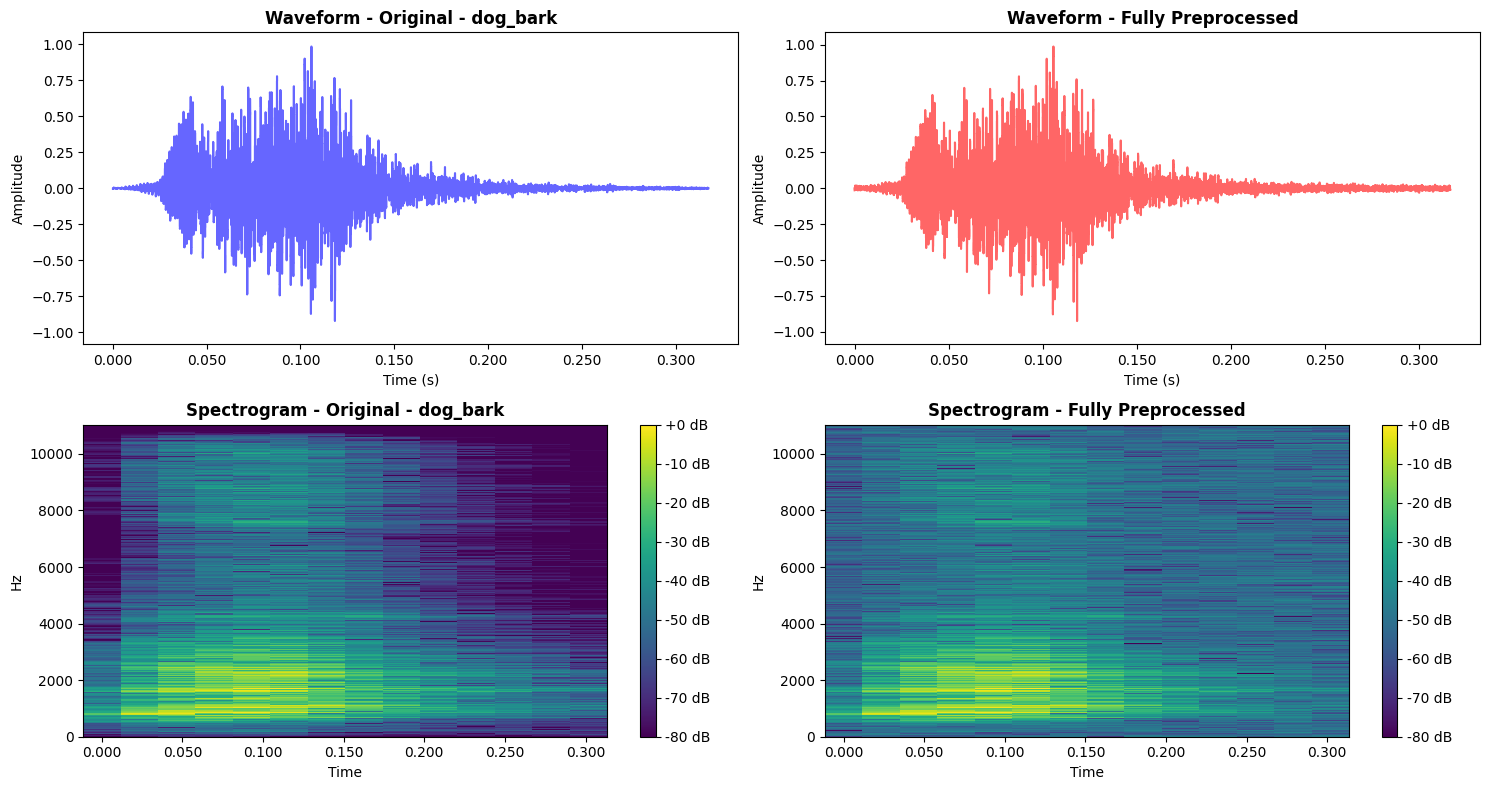


Sample 2: children_playing - 100263-2-0-117.wav
Original shape: (88200,)
Original duration: 4.00s
After noise: shape (88200, 1)
After crop: shape (85649, 1), duration 3.88s
After full pipeline: shape (78946, 1)


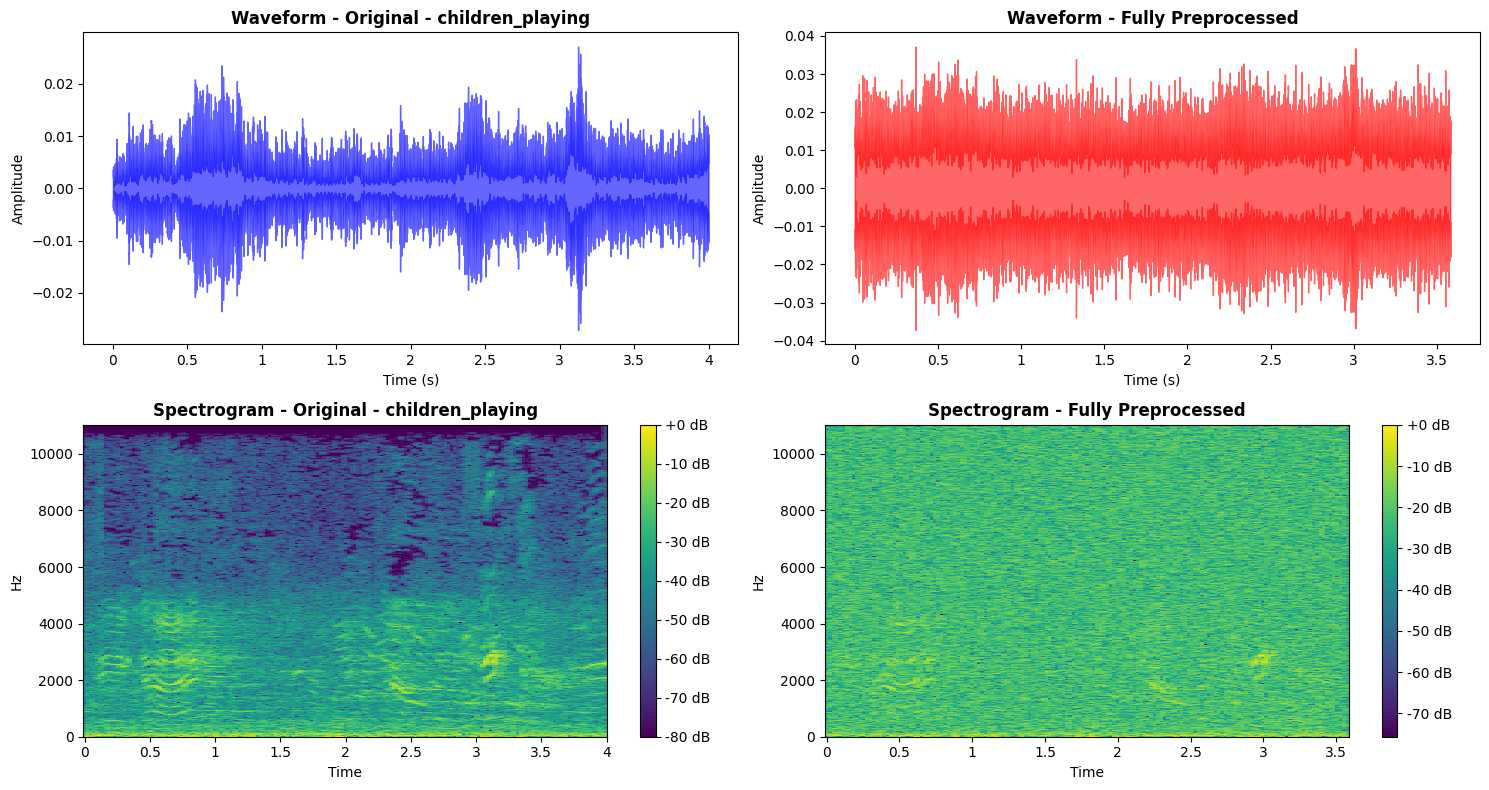


Sample 3: children_playing - 100263-2-0-121.wav
Original shape: (88200,)
Original duration: 4.00s
After noise: shape (88200, 1)
After crop: shape (87780, 1), duration 3.98s
After full pipeline: shape (74280, 1)


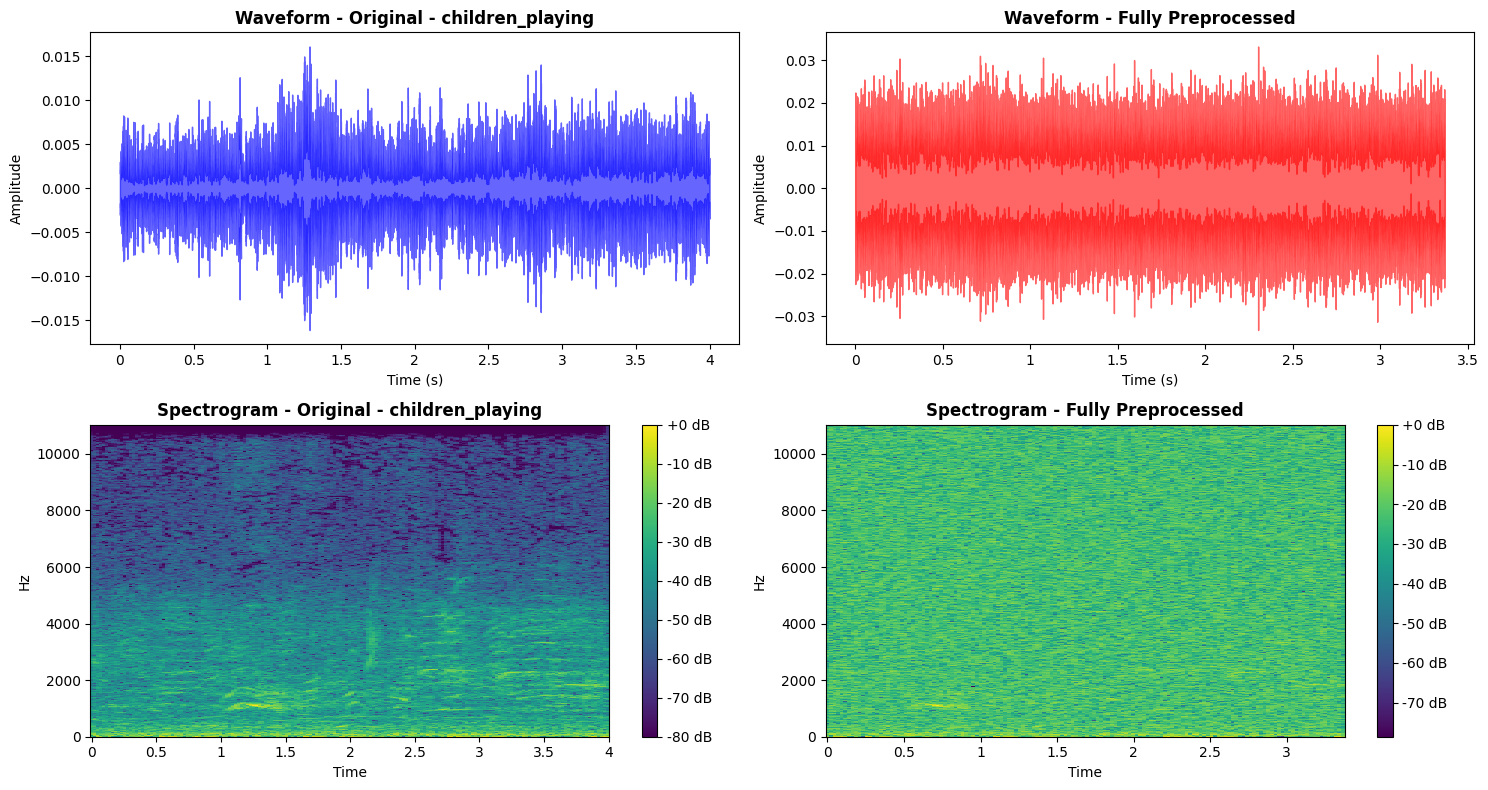

In [29]:
analyze_preprocessing_effects(df, AUDIO_BASE_PATH, num_samples=3, sr=22050)

In [ ]:
from utils import read_config

config = read_config("../config/rnn.json")

In [ ]:
import os, shutil

def clean_cache_and_aug(audio_base_path, cache_dir="../data_cache"):
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)

    for root, _, files in os.walk(audio_base_path):
        for f in files:
            if f.startswith("aug_") and f.endswith(".wav"):
                os.remove(os.path.join(root, f))

In [36]:
import datetime
import os

# clean_cache_and_aug(AUDIO_BASE_PATH)

PARENT_CACHE_DIR = "../data_cache"
os.makedirs(PARENT_CACHE_DIR, exist_ok=True)

existing_dirs = [
    d for d in os.listdir(PARENT_CACHE_DIR)
    if os.path.isdir(os.path.join(PARENT_CACHE_DIR, d))
]

if existing_dirs:
    latest_cache_name = sorted(existing_dirs)[-1]
    data_cache_dir = os.path.join(PARENT_CACHE_DIR, latest_cache_name)
    
    print(f"Found existing data cache: {data_cache_dir}. Skipping preprocessing.")
    
else:
    timestamp = datetime.datetime.now().strftime("%m%d_%H%M%S")
    data_cache_dir = os.path.join(PARENT_CACHE_DIR, timestamp)
    
    print(f"No existing cache found in {PARENT_CACHE_DIR}. Starting full data preprocessing and caching to {data_cache_dir}.")
    
    os.makedirs(data_cache_dir, exist_ok=False)
    preprocess_and_cache_folds(df, AUDIO_BASE_PATH, data_cache_dir, sr=config['sample_rate'], config=config)
    
    print(f"\nPreprocessing complete. New cache created at {data_cache_dir}")

Found existing data cache: ../data_cache/1128_230416. Skipping preprocessing.
